I want to create a model that predicts the liklyhood a batted ball in play will be a hit or not. I will use the launch angle and exit velocity as features in my model. 

I will be collecting my data using pybaseball to reteive stats from basebal savant.

In [37]:
import pybaseball as pybb
import pandas as pd
import numpy as np

data = pd.DataFrame(pybb.statcast(start_dt='2021-05-01', end_dt='2021-05-20'))
data.head(2)

#looking at the data we want to filter to only have data on balls batted in play.
#we will only need events, description, launch_speed, and launch_angle

This is a large query, it may take a moment to complete


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
1485,FF,2021-05-20,88.1,-3.42,4.16,"Cishek, Steve",663616,518553,strikeout,swinging_strike,...,7,1,7,1,7,Infield shift,Standard,234,0.0,-0.073
1539,SL,2021-05-20,77.8,-3.61,4.13,"Cishek, Steve",663616,518553,NaN,swinging_strike,...,7,1,7,1,7,Standard,Standard,70,0.0,-0.027


In [29]:
#data['if_fielding_alignment'].unique()

In [38]:
#select the desired columns
data = data[["description","events","launch_speed", "launch_angle","hc_x","hc_y"]]
#filter to only have ball hit into play
data = data[data["description"] == "hit_into_play"]



#I want to create a new column for hit or not, 1 being a hit, and 0 being any other outcome(out, error.....)
data['hit'] = [1 if x == 'single' or x == 'double' or x == 'triple' or x == 'home_run' else 0 for x in data['events']]

#Also adding hittype to show hit outcome
condition = [
    (data['events'] == "single"),
    (data['events'] == "double"),
    (data['events'] == "triple"),
    (data['events'] == "home_run")
]

choices = [1,2,3,4]

data['hitType'] = np.select(condition, choices, default=0)

data.head(10)




,description,events,launch_speed,launch_angle,hc_x,hc_y,hit,hitType
1709,hit_into_play,field_out,82.2,-6,104.55,178.94,0,0
1920,hit_into_play,single,70.6,30,180.5,126.73,1,1
2311,hit_into_play,field_out,72.2,65,126.72,152.64,0,0
2206,hit_into_play,force_out,97.3,-2,121.53,143.96,0,0
2774,hit_into_play,field_out,84.4,-29,90.04,162.88,0,0
3155,hit_into_play,field_out,92.9,41,48.78,91.02,0,0
1543,hit_into_play,double,108.2,16,98.08,43.35,1,2
1845,hit_into_play,single,62.0,0,98.15,176.18,1,1
2079,hit_into_play,home_run,103.6,33,64.12,46.7,1,4
2511,hit_into_play,single,97.3,13,100.32,75.47,1,1


Now I will plot the data to see if we can spot any patterns related to launch angle, and speed. 

In [39]:
#(data['launch_angle'].values == '').sum()
#found some empty values and need to get ride of them
data[data['launch_angle'].isna()]
data = data.dropna()

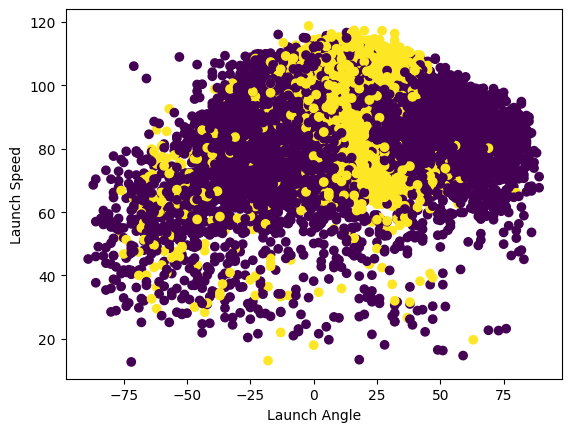

In [40]:
import matplotlib.pyplot as plt

plt.scatter(data["launch_angle"], data["launch_speed"],c=data.hit)
plt.xlabel("Launch Angle")
plt.ylabel("Launch Speed")
plt.show()

I will also consider adding the landing location of the ball. As seen in the graph below there is a bit of a pattern.

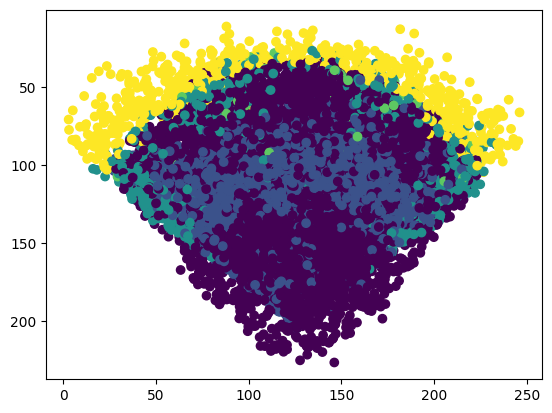

In [51]:
plt.scatter(data["hc_x"],data["hc_y"],c=data.hitType)
plt.gca().invert_yaxis()
plt.show()

Now lets start to train a model. 
I will use Logistic Regression

In [42]:
import tensorflow as tf

In [52]:
#split data into training and testing data
X = pd.DataFrame(data[['launch_angle', 'launch_speed']])
X = np.asarray(X).astype('float32')
y = pd.DataFrame(data['hit'])
split = int(len(X) * 0.8)
train_X = X[:split]
train_y = y[:split]
test_X = X[split:]
test_y = y[split:]

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(4, activation='relu', input_shape=(2,)))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_X, train_y, epochs=100, verbose=0)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0)
print("Test Accuracy:", test_acc)

Test Accuracy: 0.7676002979278564


In [63]:
model.predict([[25,20], [25,110]])

1/1 [==============================] - 0s 60ms/step


array([[0.08146015],
       [0.73335546]], dtype=float32)

In [76]:
la = np.arange(-100,101,0.25)
ev = np.arange(0,121,0.25)

la,ev = np.meshgrid(la,ev)

test = pd.DataFrame({'launch_angle':la.flatten(), 'launch_speed':ev.flatten()})
test['hit_chance'] = model.predict(test)

test.head()

12161/12161 [==============================] - 21s 2ms/step


,launch_angle,launch_speed,hit_chance
0,-100.00,0.0,0.000492
1,-99.75,0.0,0.000498
2,-99.50,0.0,0.000505
3,-99.25,0.0,0.000511
4,-99.00,0.0,0.000518
